Problem: Many small businesses in the United States require additional funds in order to start up and operate, whether it comes from crowdfunding, or from small business loans. The issue is that with rising interest rates post-pandemic, banks are hesitant to take on risk in these loans for fear of them not being paid back in full.


Question: Can the terms of a small business loan lent between 2020 and 2023 predict whether the borrower will pay it back in full or if it needs to be charged off?




Background Info: Our dataset uses data from the U.S. Small Business Administration on 504 and 7a loans which are real estate and capital loans. These loans are typically under 20 million and are prone settlements when finances go south instead of full loan forgiveness. The key to favorable terms in the settlements is to predict which loans are going to be paid back in time and which are going to need to be settled.





In [ ]:
#IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
import random
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay



In [ ]:
#Load Data

loans = pd.read_csv('https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/c71ba6cf-b4e0-4e60-98f0-48aeaf4c6460/download/foia-7afy2020-present-asof-230930.csv', encoding = 'latin-1')


<ipython-input-2-213bf44345a7>:3: DtypeWarning: Columns (34,35,39) have mixed types. Specify dtype option on import or set low_memory=False.
  loans = pd.read_csv('https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/c71ba6cf-b4e0-4e60-98f0-48aeaf4c6460/download/foia-7afy2020-present-asof-230930.csv', encoding = 'latin-1')


In [ ]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198691 entries, 0 to 198690
Data columns (total 40 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AsOfDate               198691 non-null  int64  
 1   Program                198691 non-null  object 
 2   BorrName               198689 non-null  object 
 3   BorrStreet             198691 non-null  object 
 4   BorrCity               198691 non-null  object 
 5   BorrState              198691 non-null  object 
 6   BorrZip                198691 non-null  int64  
 7   BankName               198691 non-null  object 
 8   BankFDICNumber         179739 non-null  float64
 9   BankNCUANumber         5827 non-null    float64
 10  BankStreet             198691 non-null  object 
 11  BankCity               198691 non-null  object 
 12  BankState              198691 non-null  object 
 13  BankZip                198691 non-null  int64  
 14  GrossApproval          198687 non-nu

In [ ]:
#Drop Columns (Non-predictive)

to_drop = ['AsOfDate', 'Program', 'SOLDSECMRTIND', 'BorrName', 'BorrStreet', 'BorrCity', 'BorrZip', 'BankName','BankFDICNumber','BankNCUANumber','BankStreet','BankCity','BankZip','ApprovalDate','FirstDisbursementDate','NaicsCode','NaicsDescription', 'FranchiseCode', 'FranchiseName','ProjectCounty','SBADistrictOffice','CongressionalDistrict','PaidInFullDate','ChargeOffDate', 'GrossChargeOffAmount']
loans_dropped = loans.drop(columns = to_drop, axis=1)

In [ ]:
loans_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198691 entries, 0 to 198690
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   BorrState              198691 non-null  object 
 1   BankState              198691 non-null  object 
 2   GrossApproval          198687 non-null  float64
 3   SBAGuaranteedApproval  198687 non-null  float64
 4   ApprovalFiscalYear     198691 non-null  int64  
 5   DeliveryMethod         198687 non-null  object 
 6   subpgmdesc             198691 non-null  object 
 7   InitialInterestRate    198689 non-null  float64
 8   TermInMonths           198691 non-null  int64  
 9   ProjectState           198691 non-null  object 
 10  BusinessType           198690 non-null  object 
 11  BusinessAge            198579 non-null  object 
 12  LoanStatus             198691 non-null  object 
 13  RevolverStatus         198691 non-null  int64  
 14  JobsSupported          198691 non-nu

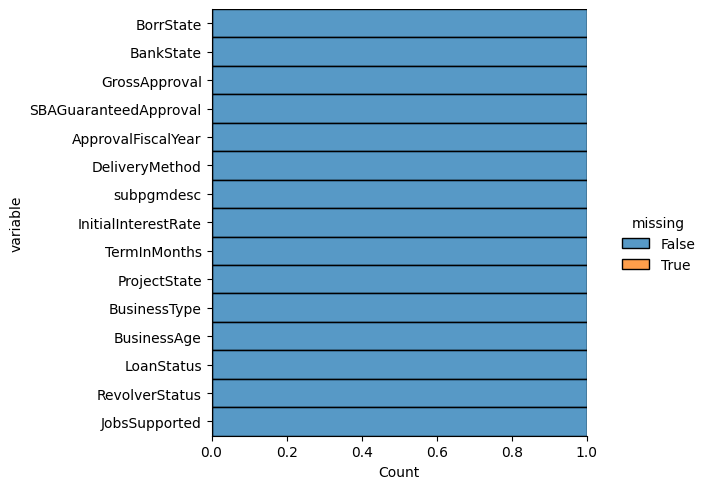

In [ ]:
#Check NAs

sns.displot(
    data=loans_dropped.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25)

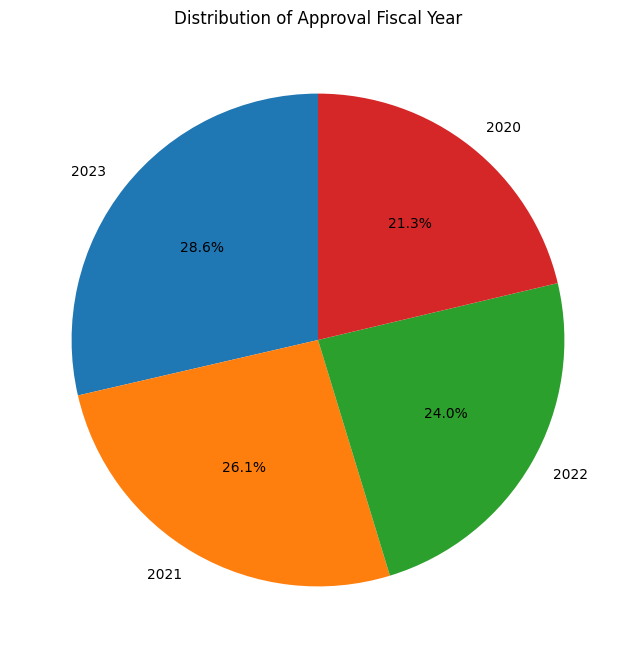

In [ ]:
year_counts = loans_dropped['ApprovalFiscalYear'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(year_counts, labels=year_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Approval Fiscal Year')
plt.show()

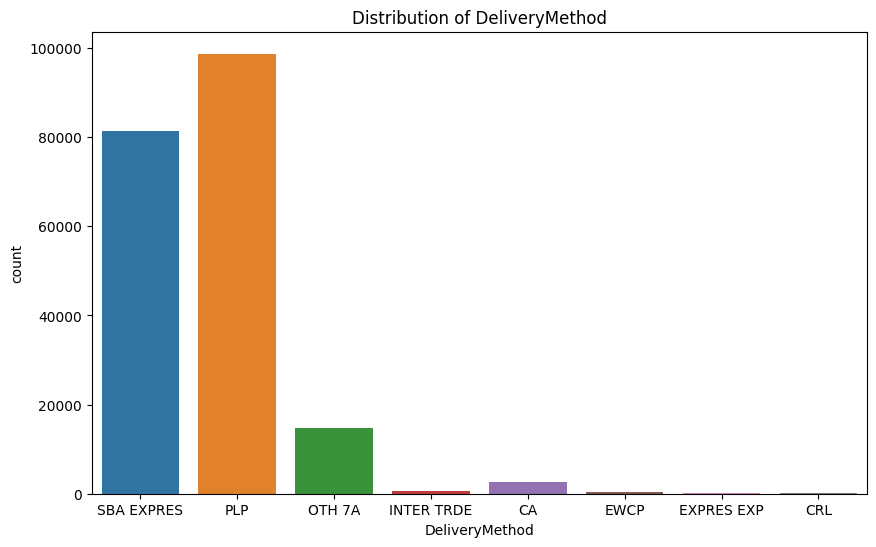

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='DeliveryMethod', data=loans_dropped)
plt.title('Distribution of DeliveryMethod')
plt.show()


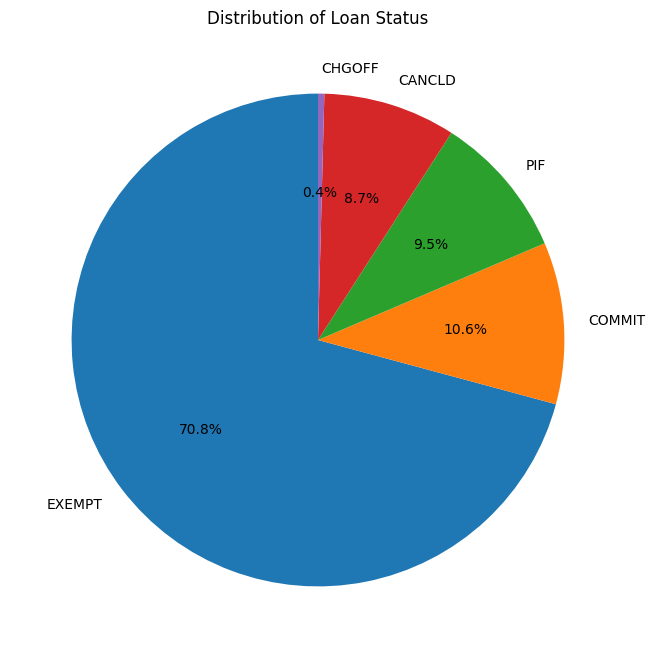

In [ ]:
status_counts = loans_dropped['LoanStatus'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Loan Status')
plt.show()

In [ ]:
state_to_region = {
    'AL': 'South', 'AK': 'West', 'AZ': 'West', 'AR': 'South', 'CA': 'West', 'CO': 'West',
    'CT': 'Northeast', 'DE': 'South', 'FL': 'South', 'GA': 'South', 'HI': 'West', 'ID': 'West',
    'IL': 'Midwest', 'IN': 'Midwest', 'IA': 'Midwest', 'KS': 'Midwest', 'KY': 'South', 'LA': 'South',
    'ME': 'Northeast', 'MD': 'South', 'MA': 'Northeast', 'MI': 'Midwest', 'MN': 'Midwest', 'MS': 'South',
    'MO': 'Midwest', 'MT': 'West', 'NE': 'Midwest', 'NV': 'West', 'NH': 'Northeast', 'NJ': 'Northeast',
    'NM': 'West', 'NY': 'Northeast', 'NC': 'South', 'ND': 'Midwest', 'OH': 'Midwest', 'OK': 'South',
    'OR': 'West', 'PA': 'Northeast', 'RI': 'Northeast', 'SC': 'South', 'SD': 'Midwest', 'TN': 'South',
    'TX': 'South', 'UT': 'West', 'VT': 'Northeast', 'VA': 'South', 'WA': 'West', 'WV': 'South',
    'WI': 'Midwest', 'WY': 'West', 'DC': 'South', 'VI': 'Territory', 'GU': 'Territory', 'PR': 'Territory'
}

# Replace state abbreviations with census regions in the 'BorrState' column
loans_dropped['BorrState'] = loans_dropped['BorrState'].replace(state_to_region)

# Replace state abbreviations with census regions in the 'BorrState' column
loans_dropped['BankState'] = loans_dropped['BankState'].replace(state_to_region)

# Replace state abbreviations with census regions in the 'BorrState' column
loans_dropped['ProjectState'] = loans_dropped['ProjectState'].replace(state_to_region)

region_to_number = {
    'Midwest': 1,
    'South': 2,
    'Northeast': 3,
    'West': 4,
    'Territory': 5
}

# Replace state abbreviations with census regions in the 'BorrState' column
loans_dropped['BorrState'] = loans_dropped['BorrState'].replace(region_to_number)

# Replace state abbreviations with census regions in the 'BorrState' column
loans_dropped['BankState'] = loans_dropped['BankState'].replace(region_to_number)

# Replace state abbreviations with census regions in the 'BorrState' column
loans_dropped['ProjectState'] = loans_dropped['ProjectState'].replace(region_to_number)




In [ ]:
# Mapping of categories to numerical codes
category_mapping_business_type = {
    'CORPORATION': 1,
    'INDIVIDUAL': 2,
    'PARTNERSHIP': 3
}

# Adding a new column with numerical codes based on BusinessType column
loans_dropped['BusinessType'] = loans_dropped['BusinessType'].map(category_mapping_business_type)

In [ ]:
category_mapping_business_age = {
    'Existing or more than 2 years old': 1,
    'New Business or 2 years or less': 2,
    'Startup, Loan Funds will Open Business': 3,
    'Change of Ownership': 4,
    'Unanswered': 5
}

# Adding a new column with numerical codes based on BusinessAge column
loans_dropped['BusinessAge'] = loans_dropped['BusinessAge'].map(category_mapping_business_age)

In [ ]:
year_to_identifier = {
    2020: 1,
    2021: 2,
    2022: 3,
    2023: 4
}

loans_dropped["ApprovalFiscalYear"] = loans_dropped["ApprovalFiscalYear"].replace(year_to_identifier)

In [ ]:
delivery_method_to_identifier = {
    'PLP': 1,
    'SBA EXPRES': 2,
    'OTH 7A': 3,
    'CA': 4,
    'INTER TRDE': 5,
    'EWCP': 6,
    'EXPRES EXP': 7,
    'CRL': 8
}

loans_dropped["DeliveryMethod"] = loans_dropped["DeliveryMethod"].replace(delivery_method_to_identifier)

In [ ]:
subpgmdesc_identifier = {
    'Guaranty': 1,
    'FA$TRK (Small Loan Express)': 2,
    'Community Advantage Initiative': 3,
    'Standard Asset Based': 4,
    'International Trade - Sec, 7(a) (16)': 5,
    'Revolving Line of Credit Exports - Sec. 7(a) (14)': 6,
    'Contract Guaranty': 7,
    'Seasonal Line of Credit': 8,
    'Small General Contractors - Sec. 7(a) (9)': 9
}

loans_dropped["subpgmdesc"] = loans_dropped["subpgmdesc"].replace(subpgmdesc_identifier)

In [ ]:
# Dropping 'EXEMPT' statuses
loans_dropped = loans_dropped[loans_dropped['LoanStatus'] != 'EXEMPT']
loans_dropped = loans_dropped[loans_dropped['LoanStatus'] != 'CANCLD']

loan_status_to_identifier = {

    'COMMIT': 0,
    'PIF': 0,
    'CHGOFF': 1
}

# Replace values in the "LoanStatus" column using the mapping
loans_dropped["LoanStatus"] = loans_dropped["LoanStatus"].replace(loan_status_to_identifier)

In [ ]:
# # Count NaN values in each row
loans_dropped = loans_dropped.dropna()

# Count NaN values in each row (61 records removed)
na_count_per_row = loans_dropped.isna().sum(axis=1)

loans_dropped.reset_index(drop=True, inplace=True)

na_count_per_row.value_counts()

0    40677
dtype: int64

In [ ]:
loan_status_counts = loans_dropped['LoanStatus'].value_counts()
print(loan_status_counts)
prevalence = loans_dropped['LoanStatus'].value_counts()[1] / loans_dropped['LoanStatus'].count()
print(prevalence)

0    39890
1      787
Name: LoanStatus, dtype: int64
0.019347542837475723


In [ ]:
loans_dropped

,BorrState,BankState,GrossApproval,SBAGuaranteedApproval,ApprovalFiscalYear,DeliveryMethod,subpgmdesc,InitialInterestRate,TermInMonths,ProjectState,BusinessType,BusinessAge,LoanStatus,RevolverStatus,JobsSupported
0,4,4,350000.0,175000.0,1,2.0,2,5.50,63,4,1.0,1.0,0,0,0
1,2,4,22000.0,11000.0,1,2.0,2,9.00,51,2,2.0,1.0,1,0,2
2,4,1,49000.0,24500.0,1,2.0,2,11.50,120,4,1.0,1.0,0,1,0
3,3,4,57000.0,28500.0,1,2.0,2,7.25,36,3,1.0,1.0,0,0,6
4,4,1,101000.0,50500.0,1,2.0,2,9.75,84,4,1.0,1.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40672,3,2,100000.0,50000.0,4,2.0,2,14.50,120,3,1.0,2.0,0,0,5
40673,1,1,736000.0,552000.0,4,1.0,1,8.50,300,1,1.0,3.0,0,0,6
40674,3,3,1715000.0,1286250.0,4,1.0,1,11.00,120,3,1.0,2.0,0,0,8
40675,2,1,982000.0,736500.0,4,1.0,1,11.25,120,2,1.0,2.0,0,0,72


In [ ]:
# Separate features (X) and target variable (y)
X = loans_dropped.drop('LoanStatus', axis=1).drop('TermInMonths', axis = 1)
y = loans_dropped['LoanStatus']

# List of columns to leave untouched
columns_to_leave_untouched = ['BusinessAge', 'ApprovalFiscalYear', 'BusinessType', 'BorrState', 'BankState', 'ProjectState', 'DeliveryMethod', 'subpgmdesc', 'LoanStatus']

# List of columns to scale
columns_to_scale = [col for col in X.columns if col not in columns_to_leave_untouched]


# Create a copy of your features
X_scaled = X.copy()

# Scale only selected columns
scaler = StandardScaler()
X_scaled[columns_to_scale] = scaler.fit_transform(X_scaled[columns_to_scale])

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=5)

# Initialize the model

model = RandomForestClassifier(max_depth = 13, random_state=5, class_weight = "balanced")

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9314159292035398


In [ ]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print(feature_importance_df)

                  Feature  Importance
4      ApprovalFiscalYear    0.267865
7     InitialInterestRate    0.188117
2           GrossApproval    0.163698
3   SBAGuaranteedApproval    0.122982
12          JobsSupported    0.081430
10            BusinessAge    0.038056
1               BankState    0.035308
8            ProjectState    0.023609
0               BorrState    0.023314
11         RevolverStatus    0.016649
5          DeliveryMethod    0.014617
6              subpgmdesc    0.013887
9            BusinessType    0.010467


In [ ]:
proba_pos= model.predict_proba(X_test)[:, 1]
best_row_index = proba_pos.argmax()
print(best_row_index)

print(X.iloc[best_row_index])

1808
BorrState                     2.00
BankState                     2.00
GrossApproval            106500.00
SBAGuaranteedApproval     90525.00
ApprovalFiscalYear            1.00
DeliveryMethod                1.00
subpgmdesc                    1.00
InitialInterestRate           5.75
ProjectState                  2.00
BusinessType                  1.00
BusinessAge                   1.00
RevolverStatus                0.00
JobsSupported                23.00
Name: 1808, dtype: float64


In [ ]:
proba_pos= model.predict_proba(X_test)[:, 1]
worst_row_index = proba_pos.argmin()
print(worst_row_index)

print(X.iloc[worst_row_index])

0
BorrState                     4.0
BankState                     4.0
GrossApproval            350000.0
SBAGuaranteedApproval    175000.0
ApprovalFiscalYear            1.0
DeliveryMethod                2.0
subpgmdesc                    2.0
InitialInterestRate           5.5
ProjectState                  4.0
BusinessType                  1.0
BusinessAge                   1.0
RevolverStatus                0.0
JobsSupported                 0.0
Name: 0, dtype: float64


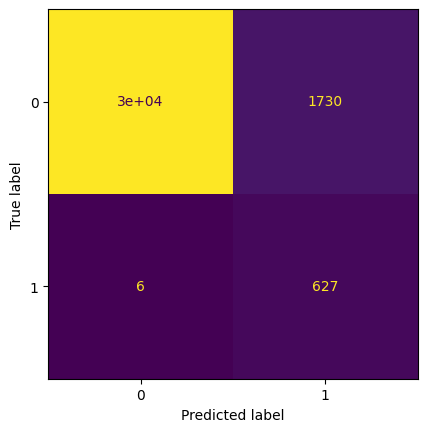

In [ ]:
ConfusionMatrixDisplay.from_estimator(model,X_train,y_train, colorbar= False)

Text(0.5, 0, 'False Positive Rate')

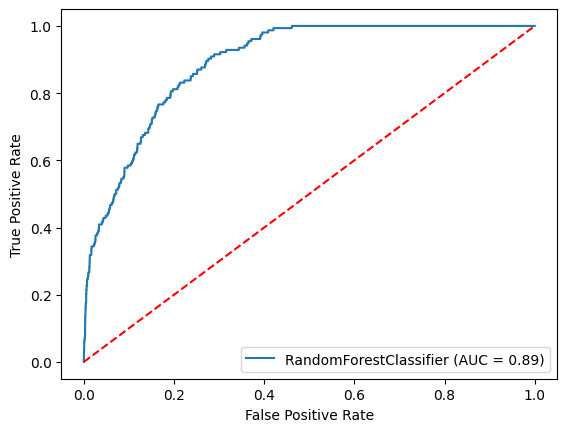

In [ ]:
metrics.RocCurveDisplay.from_estimator(model, X_test,y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
true_positives = conf_matrix[1, 1]
false_negatives = conf_matrix[1, 0]

print('Precision: ' + str(precision_score(y_test, y_pred, pos_label= 1)))
print('Recall: ' + str(true_positives / (true_positives + false_negatives)))

Precision: 0.13138686131386862
Recall: 0.4675324675324675


In [ ]:
X2 = loans_dropped.drop('LoanStatus', axis=1).drop('TermInMonths', axis = 1).drop('InitialInterestRate', axis = 1)
y2 = loans_dropped['LoanStatus']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.70, stratify = y2, random_state=21)
X2_tune, X2_test, y2_tune, y2_test = train_test_split(X2_test,y2_test,  train_size = 0.50, stratify = y2_test,random_state=49)

loan_NN = KNeighborsClassifier(n_neighbors=10)

loan_NN.fit(X2_train, y2_train)

loan_NN.score(X2_tune, y2_tune)

0.9793510324483776